# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [5]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact

In [6]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [7]:
# Import the necessary CSVs to Pandas DataFrames
# YOUR CODE HERE!
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
neighborhood_data = pd.read_csv(file_path, index_col="year")
file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_loc = pd.read_csv(file_path)
neighborhood_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [8]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units = neighborhood_data["housing_units"]
    housing_units = housing_units.groupby([neighborhood_data.index]).mean()
    housing_units_fig = plt.figure()
    housing_units_plot = housing_units.plot.bar(x='year', ylim=[370000, 385000], title="Average Number of Housing Units Sold per Year")
    plt.close(housing_units_fig)
    return pn.pane.Matplotlib(housing_units_fig)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    average_rent = neighborhood_data["gross_rent"].groupby([neighborhood_data.index]).mean()
    gross_rent_fig = plt.figure()
    average_rent_plot = (average_rent.plot.line(x='year', y='gross_rent', title="Average Gross Rent per Year"))
    plt.close(gross_rent_fig)
    return pn.pane.Matplotlib(gross_rent_fig)
    



def average_sales_price():
    """Average Sales Price Per Year."""
    average_price_sqr_foot = neighborhood_data["sale_price_sqr_foot"].groupby([neighborhood_data.index]).mean()
    sales_price_fig = plt.figure()
    average_price_plot = (average_price_sqr_foot.plot.line(x='year', y='sale_price_sqr_foot', title="Average Sales Price per Year"))
    plt.close(sales_price_fig)
    return pn.pane.Matplotlib(sales_price_fig)



def average_price_by_neighborhood(neighborhood):
    """Average Prices by Neighborhood."""
    sf_data_new = neighborhood_data.groupby([neighborhood_data.index, "neighborhood"]).mean()
    sfo_sales = sf_data_new["sale_price_sqr_foot"]
    sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
    return sfo_sales_df.loc[sfo_sales_df["neighborhood"]==neighborhood,:].hvplot.line(
        x="year",
        y="sale_price_sqr_foot",
        colormap="coolwarm",
        title="SF Sale per Square foot per Year",
    )

sf_data_new = neighborhood_data.groupby([neighborhood_data.index, "neighborhood"]).mean()
sfo_sales = sf_data_new["sale_price_sqr_foot"]
sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
neighborhood_choice = sfo_sales_df["neighborhood"].unique()
interact(average_price_by_neighborhood, neighborhood=neighborhood_choice)

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    avg_value_per_neighborhood = neighborhood_data.groupby([neighborhood_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top10_plot = px.bar(top_10_most_expensive,
    x="neighborhood",
    y="sale_price_sqr_foot",
    title="Top 10 Most Expensive Neighborhoods in San Francisco",
    )
    return top10_plot
    


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    avg_value_per_neighborhood = neighborhood_data.groupby([neighborhood_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'gross_rent').reset_index()
    top10_plot = px.bar(top_10_most_expensive,
    x="neighborhood",
    y="gross_rent",
    title="Top 10 Most Expensive Neighborhoods in San Francisco by rent",
    )
    return top10_plot
    

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    avg_value_per_neighborhood = neighborhood_data.groupby([neighborhood_data["neighborhood"]]).mean()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel = px.parallel_coordinates(
    top_10_most_expensive,
    color='sale_price_sqr_foot')
    return top_10_parallel
    



def parallel_categories():
    """Parallel Categories Plot."""
    avg_value_per_neighborhood = neighborhood_data.groupby([neighborhood_data["neighborhood"]]).mean()
    top_10_ex_neighborhood = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel_categories = px.parallel_categories(
    top_10_ex_neighborhood,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
)
    return top_10_parallel_categories
    



def neighborhood_map():
    """Neighborhood Map."""
    file_path = Path("Data/neighborhoods_coordinates.csv")
    df_neighborhood_location = pd.read_csv(file_path)
    avg_value_per_neighborhood = neighborhood_data.groupby([neighborhood_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    avg_value_location = pd.concat([avg_value_per_neighborhood, df_neighborhood_location], axis="columns", join="inner")
    location_map = px.scatter_mapbox(
    avg_value_location,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale=px.colors.cyclical.IceFire,
    #title="Average Sale Price per Square Foot and Gross Rent in San Francisco",
    zoom=11,
    width=800,
)
    return location_map
    




def sunburst():
    """Sunburst Plot."""
    
    # YOUR CODE HERE!


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [9]:
# Create a Title for the Dashboard
# YOUR CODE HERE!
title = '#Real Estate Analysis of San Francisco from 2010-2016'
welcome_tab = pn.Row(pn.Column(title), neighborhood_map())
market_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())
# Create a tab layout for the dashboard
neighborhood_analysis_tab = pn.Column(interact(average_price_by_neighborhood, neighborhood=neighborhood_choice),
    top_most_expensive_neighborhoods(),
    most_expensive_neighborhoods_rent_sales()
)
parallel_plots_tab = pn.Column(
    parallel_categories(),
    parallel_coordinates()
)


# Create a tab layout for the dashboard
# YOUR CODE HERE!
SF_dashboard = pn.Tabs(("Welcome", welcome_tab),
("Yearly Analysis", market_analysis_row),
("Neighborhood Market", neighborhood_analysis_tab),
("Neighborhood Market Analysis", parallel_plots_tab))

# Create the dashboard
# YOUR CODE HERE!

## Serve the Panel Dashboard

Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Column
            [0] Column
                [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Curve, name='interactive01559')
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
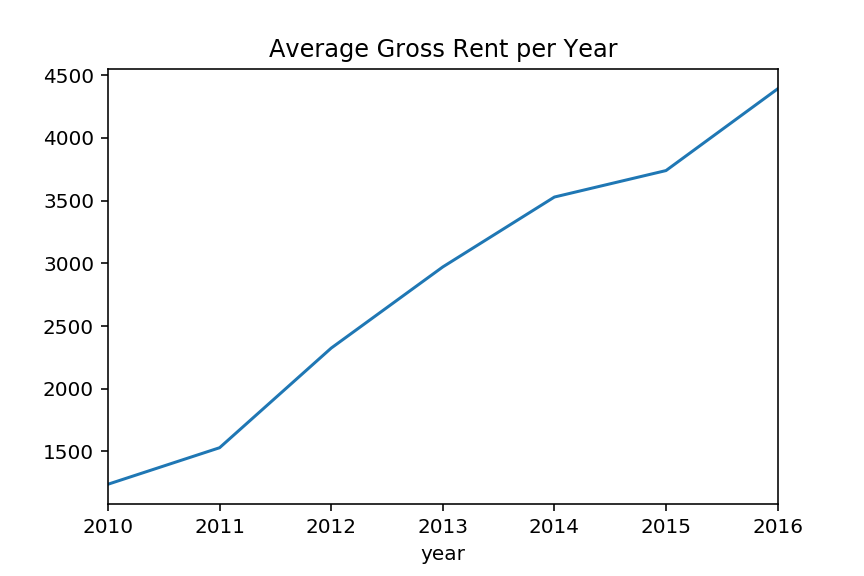
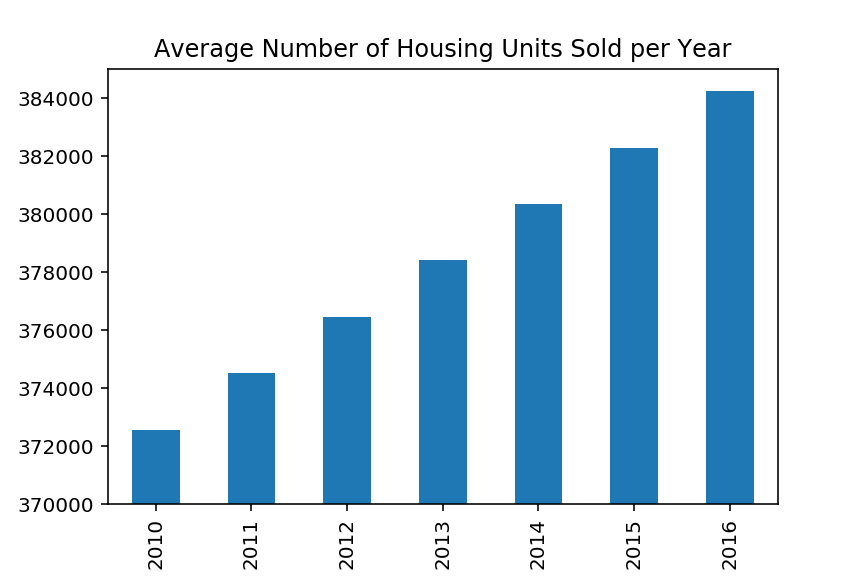
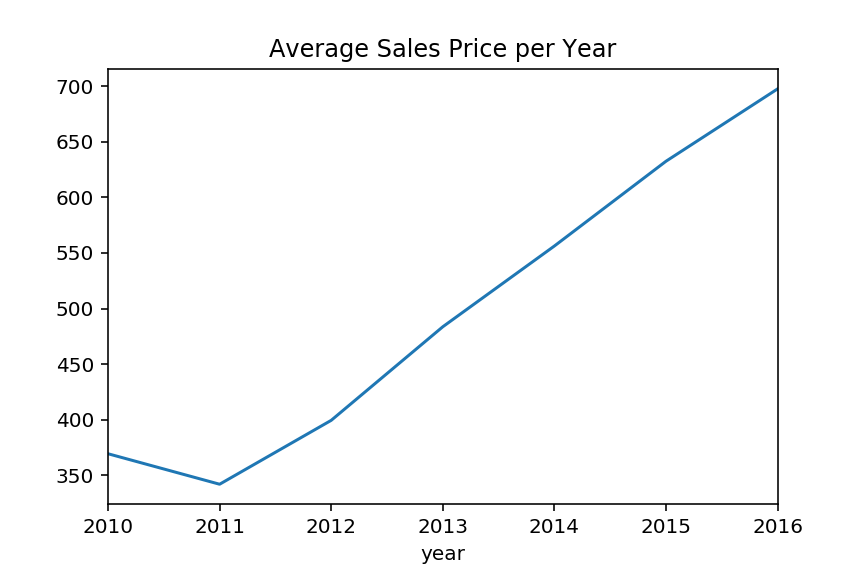

In [10]:
# Serve the# dashboard
# YOUR CODE HERE!
SF_dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [ ]:
# housing_units_per_year()

In [ ]:
# average_gross_rent()

In [ ]:
# average_sales_price()

In [ ]:
# average_price_by_neighborhood()

In [ ]:
# top_most_expensive_neighborhoods()

In [ ]:
# most_expensive_neighborhoods_rent_sales()

In [ ]:
# neighborhood_map().show()

In [ ]:
# parallel_categories()

In [ ]:
# parallel_coordinates()

In [ ]:
# sunburst()